## Fruits Ripness Detection

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2024-03-18 16:49:50.417330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Set constant

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=40

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1693 files belonging to 9 classes.


In [4]:
class_names = dataset.class_names
class_names

['OverripeApple',
 'OverripeBanana',
 'OverripeOrange',
 'RipeApple',
 'RipeBanana',
 'RipeOrange',
 'UnripeApple',
 'UnripeBanana',
 'UnripeOrange']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[8 0 1 7 0 7 1 5 4 8 5 0 1 1 6 3 6 7 6 8 6 5 7 2 5 2 8 0 5 8 5 8]


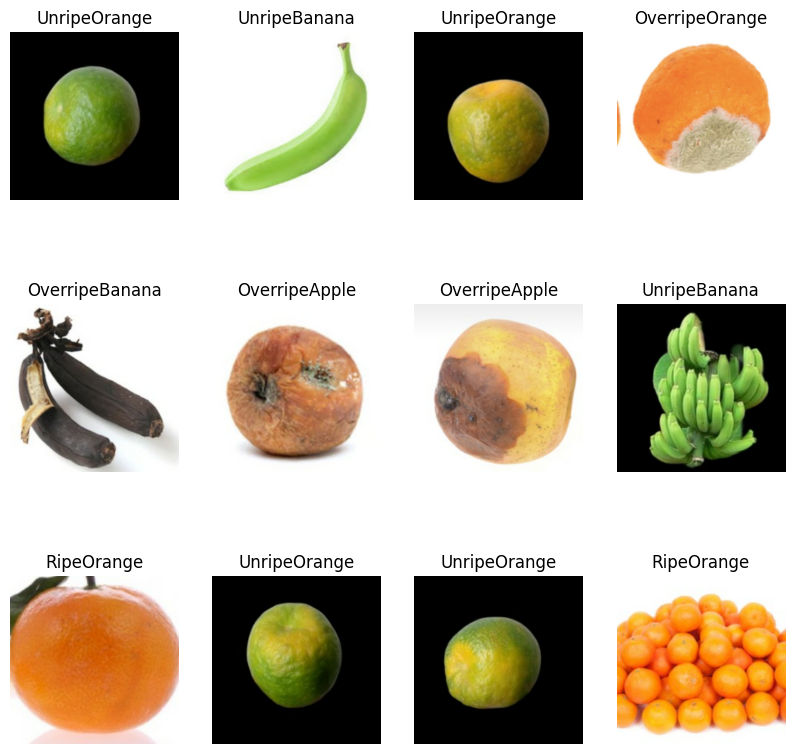

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

42

In [10]:
len(val_ds)

5

In [11]:
len(test_ds)

6

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Trained Dataset

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model 3.1.2 Try

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 149, 149, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 73, 73, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 71, 71, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
%%time
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
    callbacks=[early_stopping]
)

Epoch 1/40
42/42 [==============================] - ETA: 0s - loss: 1.7582 - accuracy: 0.3318

2024-03-18 16:59:09.567049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 49 of 10000
2024-03-18 16:59:10.147953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-03-18 16:59:11.255816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


42/42 [==============================] - 290s 7s/step - loss: 1.7582 - accuracy: 0.3318 - val_loss: 1.3771 - val_accuracy: 0.4375
Epoch 2/40
42/42 [==============================] - 303s 7s/step - loss: 1.2462 - accuracy: 0.5011 - val_loss: 1.2130 - val_accuracy: 0.4437
Epoch 3/40
42/42 [==============================] - 346s 8s/step - loss: 1.0398 - accuracy: 0.5981 - val_loss: 0.9834 - val_accuracy: 0.6187
Epoch 4/40
42/42 [==============================] - 326s 8s/step - loss: 0.8125 - accuracy: 0.7054 - val_loss: 0.7393 - val_accuracy: 0.7063
Epoch 5/40
42/42 [==============================] - 271s 6s/step - loss: 0.6920 - accuracy: 0.7405 - val_loss: 0.8182 - val_accuracy: 0.6812
Epoch 6/40
42/42 [==============================] - 220s 5s/step - loss: 0.6072 - accuracy: 0.7785 - val_loss: 0.5559 - val_accuracy: 0.7937
Epoch 7/40
42/42 [==============================] - 246s 6s/step - loss: 0.5699 - accuracy: 0.7890 - val_loss: 0.6941 - val_accuracy: 0.7875
Epoch 8/40
42/42 [======

In [27]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 8s 735ms/step - loss: 0.2082 - accuracy: 0.9427


## Model 3.1.2 accuracy 94%

In [28]:
scores

[0.20818930864334106, 0.9427083134651184]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 42}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

40

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.758245825767517,
 1.246164083480835,
 1.0398378372192383,
 0.8125320672988892,
 0.6919846534729004]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

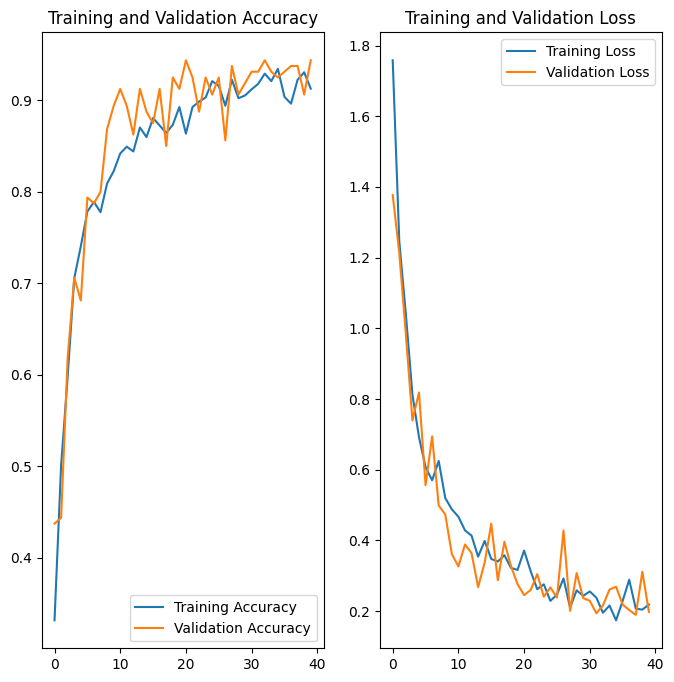

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Testing sample image

first image to predict
actual label: OverripeBanana
1/1 [==============================] - 2s 2s/step
predicted label: OverripeBanana


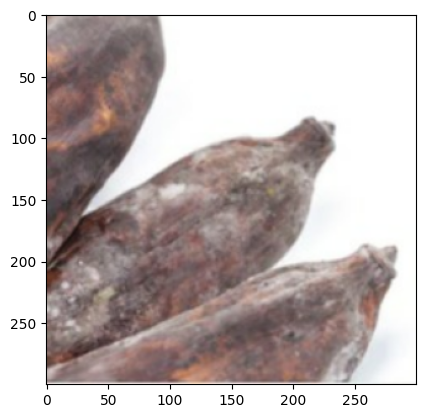

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 143ms/step


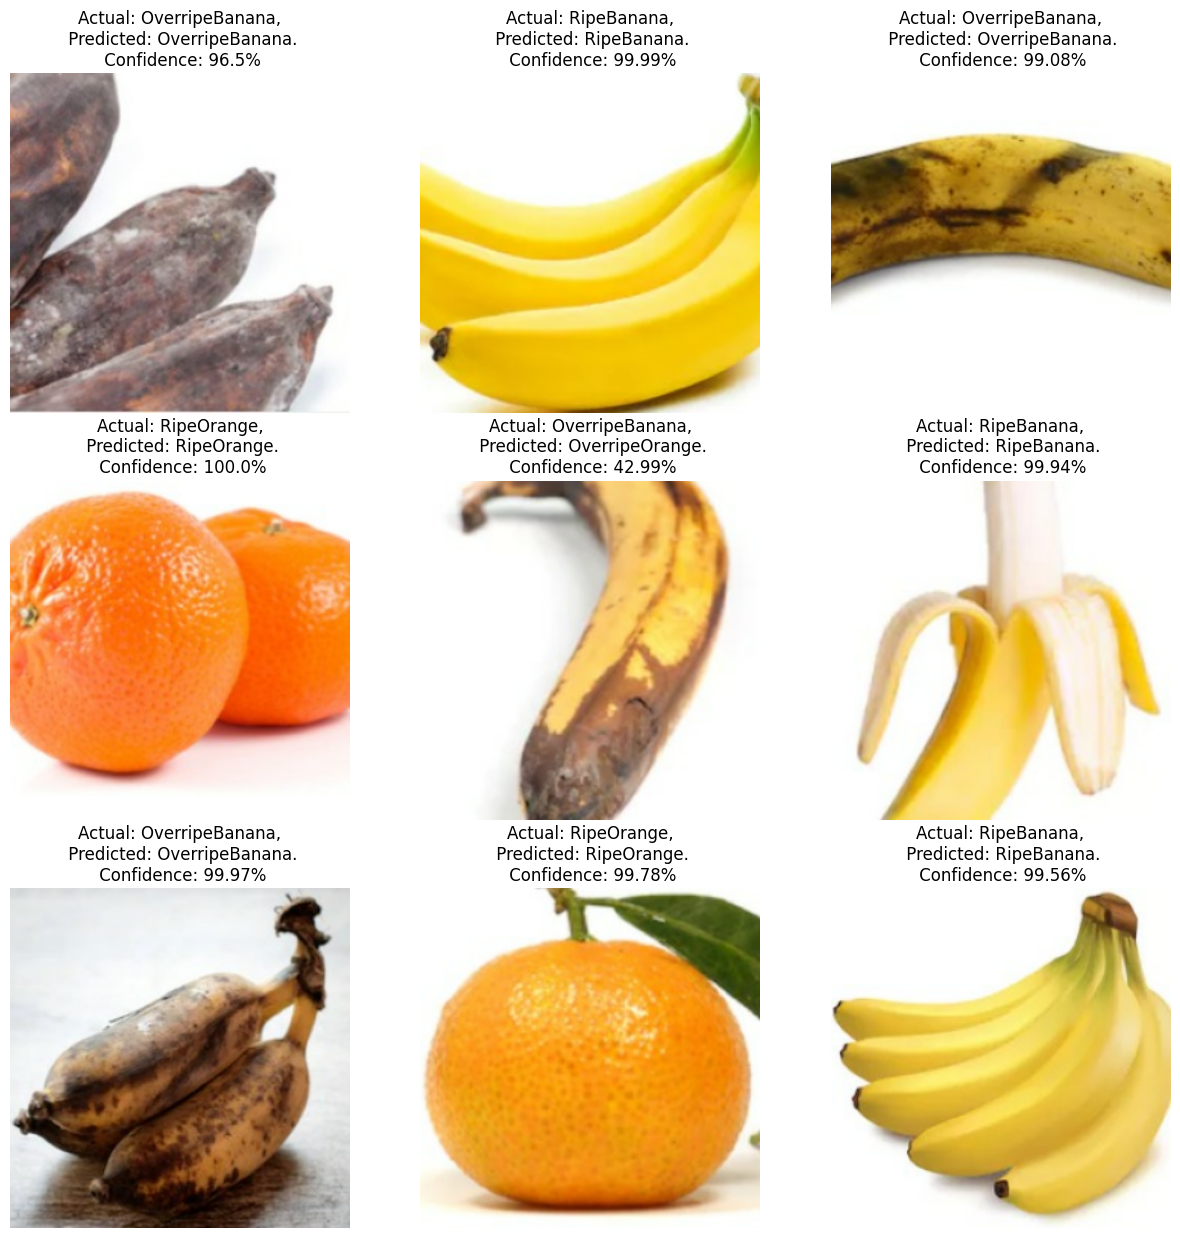

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saved 3.1.2 Model

In [42]:
import os


model_files = os.listdir("models")


model_versions = [int(filename) for filename in model_files if filename.isdigit()]

if not model_versions:
    model_version = 0
else:
    model_version = max(model_versions) + 1


model.save(f"models/{model_version}")


INFO:tensorflow:Assets written to: models/2/assets


INFO:tensorflow:Assets written to: models/2/assets


In [43]:
model.save("models/T1_SIG.h5")

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Load the saved TensorFlow model
model = tf.keras.models.load_model("models/T1_SIG.h5")

# Convert the TensorFlow model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("models/Lite_Model/model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/nk/g6frk2f507b3hrdnbkndmqxw0000gn/T/tmprh5taoa5/assets


INFO:tensorflow:Assets written to: /var/folders/nk/g6frk2f507b3hrdnbkndmqxw0000gn/T/tmprh5taoa5/assets
2024-03-24 13:29:13.500709: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-24 13:29:13.500747: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-24 13:29:13.501290: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/nk/g6frk2f507b3hrdnbkndmqxw0000gn/T/tmprh5taoa5
2024-03-24 13:29:13.578419: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-24 13:29:13.578460: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/nk/g6frk2f507b3hrdnbkndmqxw0000gn/T/tmprh5taoa5
2024-03-24 13:29:13.770153: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-24 13:29:15.354287: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()


In [ ]:
$ pip install https://dl.google.com/coral/python/tflite_runtime-2.5.0.post1-cp37-cp37m-linux_armv7l.whl


In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
